# GRAD-E1426 Network Analysis: Assignment 2 
#### Janine De Vera, 219848

## Characterizing the Depth and Scope of Trade Agreements

Over the last half century the world has seen historic changes in the international trade landscape, marked by increasing fragmentation of production processes through global value chains and deepening of trade relations through **preferential trade agreements (PTAs)**. Based on the World Trade Organization's (WTO) database, the number of trade agreements in force grew seven-fold from 50 in 1990 to 355 in 2022. 

The sharp rise in trade agreements sparked a new research interest in the depth and scope of their contents. Before the mid 1990s, PTAs mostly invovled provisions for market access and preferential tariffs. In the last 30 years new forms of cooperation have spread and trade agreements have become deeper, making room for provisions outside the scope of the WTO mandate such as data protection, intellectual property, human rights, and environmental laws. 

This exercise provides a descriptive analysis of trade agreement networks, focusing on characteritizing how the scope of agreements have changed over time and identifying key actors (i.e. economies) that drive network dynamics. 

In [427]:
import graph_tool.all as gt
import graph_tool.stats as gt_stats
import matplotlib
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.pyplot import clf, xlabel, ylabel, imshow, colorbar, savefig
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import os
import math


In [2]:
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Semester 4/2 Network Analysis/Assignments/network-analysis-trade-agreements/code'

## I. Data

For this analysis, I use the <a href="https://datatopics.worldbank.org/dta/table.html"> *Horizontal Trade Agreements Database*</a> compiled by the World Bank. This dataset contains preferential trade agreements (PTAs) notified to the World Trade Organization as of 2015. For each agreement the following variables are provided: trade partners, year of enforcement, PTA type, indicators of presence (or absence) of 52 PTA provisions, and legal enforceability of each provision. All information is recorded bilaterally, as seen below. 

There are two main types of provisions - _**wto_plus**_ and _**wto_x**_. The former includes PTA provisions under the mandate of the WTO such as anti-dumping policies, customs duties and export taxes. The latter, _**wto_x**_ (WTO extra), pertains to provisions outside the mandate of the WTO such as consumer protection, environmental laws, cultural cooperation, and immigration policies.

The _**depth**_ variable measures the scope of a trade agreement by summing the number of key PTA provisions that appear in a particular agreement. The maximum possible value is 52. Similarly, the _**depth_le**_ variable is a measure of depth and scope, but only includes legally enforceable provisions. 

In [3]:
pta = pd.read_excel("../data/WB_Bilateral PTAs.xlsx")

In [4]:
pta['depth'] = pta.filter(regex=r'^wto(?!.*_le$)').sum(axis=1)
pta['depth_le'] = pta.filter(regex=r'^wto.*_le$').sum(axis=1)
pta.head()

cty1 iso1     cty2 iso2  year agreement  entry_force type   
0  Angola  AGO  Burundi  BDI  1994    COMESA         1994   CU  \
1  Angola  AGO  Burundi  BDI  1995    COMESA         1994   CU   
2  Angola  AGO  Burundi  BDI  1996    COMESA         1994   CU   
3  Angola  AGO  Burundi  BDI  1997    COMESA         1994   CU   
4  Angola  AGO  Burundi  BDI  1998    COMESA         1994   CU   

   wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...   
0                       1                        1  ...  \
1                       1                        1  ...   
2                       1                        1  ...   
3                       1                        1  ...   
4                       1                        1  ...   

   wto_X_regionalcooperation_le  wto_X_researchandtechnology_le  wto_X_sme_le   
0                             0                               0             0  \
1                             0                               0             0   
2                             0                               0             0   
3                             0                               0             0   
4                             0                               0             0   

   wto_X_socialmatters_le  wto_X_statistics_le  wto_X_taxation_le   
0                       0                    0                  0  \
1                       0                    0                  0   
2                       0                    0                  0   
3                       0                    0                  0   
4                       0                    0                  0   

   wto_X_terrorism_le  wto_X_visaandasylum_le  depth  depth_le  
0                   0                       0     29        22  
1                   0                       0     29        22  
2                   0                       0     29        22  
3                   0                       0     29        22  
4                   0                       0     29        22  

[5 rows x 114 columns]

The 52 PTA provisions in the dataset cover a wide range of cooperation areas. <a href="https://www.sciencedirect.com/science/article/abs/pii/S2214312216300138?via%3Dihub">Limao (2016)</a> categorises them into 9 groups - (i) import tariffs, (ii) non-tariff barriers, (iii) behind the border policies, (iv) other policies, (v) services, (vi) technology, (vii) investment/capital, (viii) labor, and (ix) non-economic policies.

For the exploratory data analysis in later sections, I focus on agreements that contain legally binding commitments on **non-economic policies**. The provisions included in this category are environmental laws, audiovisual cooperation, cultural cooperation, health, human rights, illicit drugs, money laundering, political dialogue, and terrorism. To be able to use this information, I create an indicator variable for whether an agreement contains at least one legally enforceable non-economic policy. 

In [5]:
# indicator variable for wto_x_le
pta['wto_x_le'] = 0
for column in pta.columns:
    if "wto_X" in column and "_le" in column:
        pta['wto_x_le'] = pta['wto_x_le'] | (pta[column] > 0)
pta['wto_x_le'] = pta['wto_x_le'].astype(int)

# indicator variable for wto_x_nonecon
non_econ = ['wto_X_environmentallaws_le', 'wto_X_audiovisual_le', 'wto_X_culturalcooperation_le', 'wto_X_health_le', 'wto_X_humanrights_le', 
            'wto_X_illicitdrugs_le', 'wto_X_moneylaundering_le', 'wto_X_politicaldialogue_le', 'wto_X_terrorism_le', ]
pta['wto_x_nonecon'] = 0
for column in pta.columns:
    if column in non_econ:
        pta['wto_x_nonecon'] = pta['wto_x_nonecon'] | (pta[column] > 0)
pta['wto_x_nonecon'] = pta['wto_x_nonecon'].astype(int)

I also supplement the dataset with other country-level information such as broad geographic region, economy size, and income classification. These can be added as additional features of the network.

In [6]:
regions = pd.read_excel("../data/WB_regions.xls", skiprows=4, index_col=0)
regions = regions[['Economy', 'Code', 'Region_Clean', 'Income group']].dropna(subset = ['Region_Clean'])

In [7]:
economy = pd.read_excel("../data/WB_economy.xlsx")
economy = (economy
           .dropna(subset=['Series Code'])
           .iloc[:, [3, 13]]
           .rename(columns={economy.columns[13]: 'gdp'})) # 2019 GDP 

economy['log_gdp'] = np.log(economy['gdp'].replace('..', float('nan')).astype(float))
economy['log_gdp'] = economy['log_gdp'].fillna(economy['log_gdp'].min(skipna=True)) # fill NA values with minimum 

The final merged dataset _**trade_df**_ is constructed such that each observation is a unique country-pair agreement.

In [8]:
# merge datasets
trade_df = pd.merge(pta, regions, left_on='iso1', right_on='Code')
trade_df = pd.merge(trade_df, economy, left_on='iso1', right_on='Country Code')

In [9]:
# remove duplicate pairs
trade_df['sorted_iso'] = trade_df[['iso1', 'iso2']].apply(lambda x: tuple(sorted(x)), axis=1) # country-pair tuple
trade_df = trade_df.drop_duplicates(subset=['sorted_iso', 'agreement'], keep='first')
trade_df.head()

cty1 iso1                          cty2 iso2  year   
0   Angola  AGO                       Burundi  BDI  1994  \
14  Angola  AGO                      Botswana  BWA  2000   
30  Angola  AGO  Democratic Republic of Congo  COD  1994   
36  Angola  AGO  Democratic Republic of Congo  COD  2000   
60  Angola  AGO                       Comoros  COM  1994   

                                 agreement  entry_force type   
0                                   COMESA         1994   CU  \
14  Southern African Development Community         2000  FTA   
30                                  COMESA         1994   CU   
36  Southern African Development Community         2000  FTA   
60                                  COMESA         1994   CU   

    wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...  wto_x_le   
0                        1                        1  ...         1  \
14                       1                        1  ...         0   
30                       1                        1  ...         1   
36                       1                        1  ...         0   
60                       1                        1  ...         1   

    wto_x_nonecon  Economy  Code        Region_Clean         Income group   
0               0   Angola   AGO  Sub-Saharan Africa  Lower middle income  \
14              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   
30              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   
36              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   
60              0   Angola   AGO  Sub-Saharan Africa  Lower middle income   

    Country Code                 gdp    log_gdp  sorted_iso  
0            AGO  69309110145.768738  24.961842  (AGO, BDI)  
14           AGO  69309110145.768738  24.961842  (AGO, BWA)  
30           AGO  69309110145.768738  24.961842  (AGO, COD)  
36           AGO  69309110145.768738  24.961842  (AGO, COD)  
60           AGO  69309110145.768738  24.961842  (AGO, COM)  

[5 rows x 124 columns]

## II. Network Plots

To visualize the trade agreements network, the data has to be structured in a way that is compatible with the _**Graph()**_ class of graph-tool. I create a list of unique countries which will serve as nodes, and country-pair agreements which will serve as edges. The network is designed such that if two countries have more than one PTA with each other, there will also be more than one link between them. Country name and pair name properties for nodes and edges are also added for ease of reference.

### A. Creating *graph* object

In [10]:
# unique countries and country pair agreements
nodes = trade_df['iso1'].drop_duplicates()
pairs = trade_df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')

# edge pairs as list of tuples 
pairs = list(zip(pairs.iso1, pairs.iso2))

In [126]:
# instantiate undirected Graph object
trade_graph = gt.Graph(directed=False)

In [127]:
# add nodes and edges from pairs list, create country_name and pair_name as properties
country_name = trade_graph.new_vertex_property('string')
pair_name = trade_graph.new_edge_property('object')

node_list = {}
for pair in pairs:
    for name in pair:
        if name not in node_list:
            v = trade_graph.add_vertex() #add vertex 
            node_list[name] = v #add vertex index to node dict
            country_name[v] = name #add name of vertex index as property
    e = trade_graph.add_edge(node_list[pair[0]], node_list[pair[1]]) #add edge
    pair_name[e] = (pair[0], pair[1]) #add name of pair index as property

trade_graph.vertex_properties["country_name"] = country_name
trade_graph.edge_properties["pair_name"] = pair_name

In [19]:
# network layout: position of nodes 
pos = gt.sfdp_layout(trade_graph)

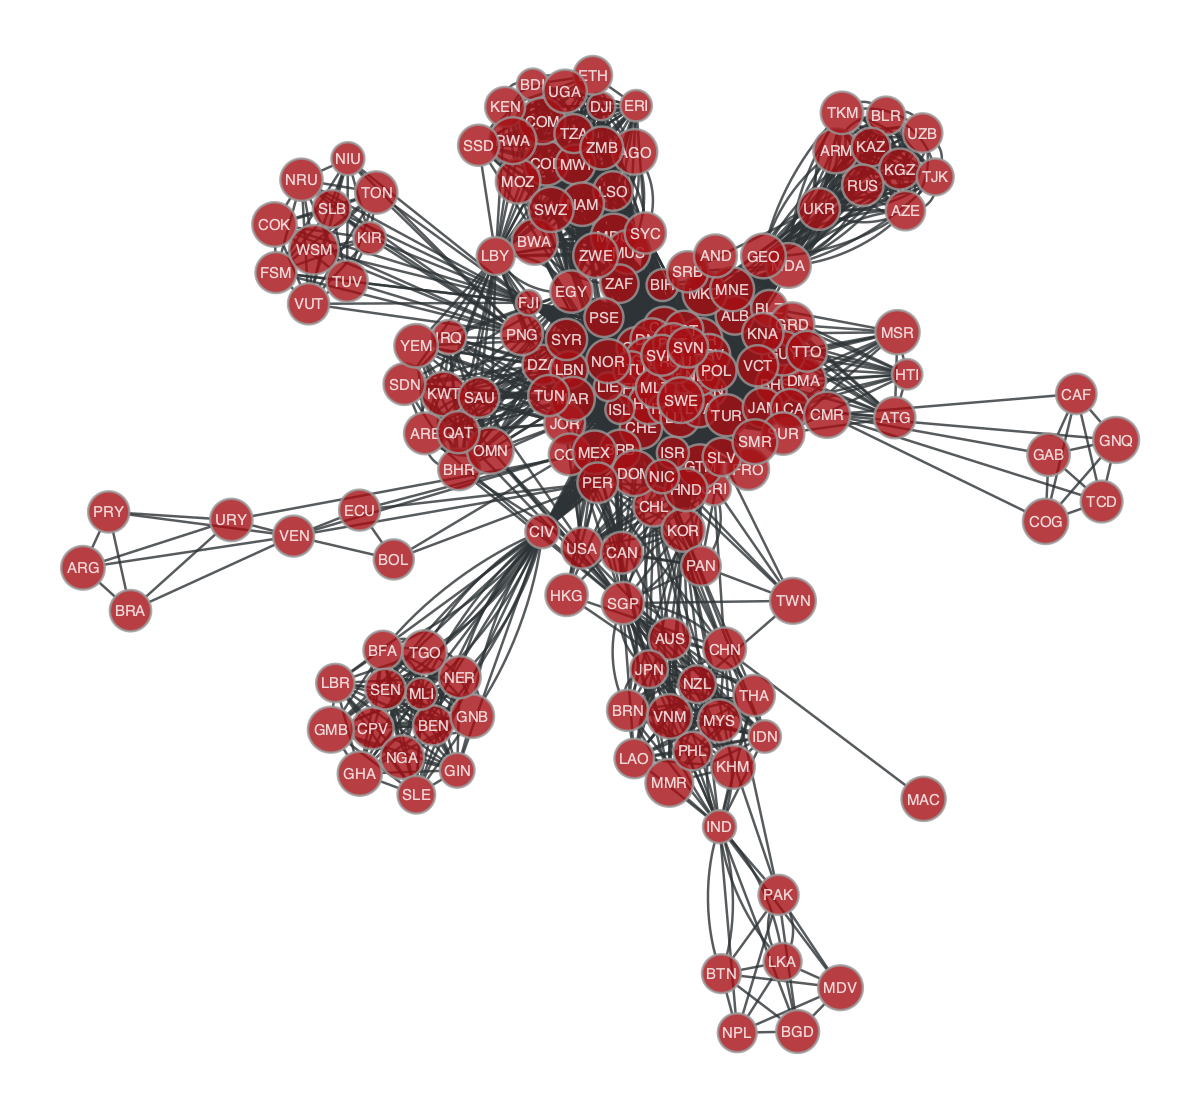

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2a2ff7cd0, at 0x28df679d0>

In [131]:
gt.graph_draw(trade_graph, pos = pos, vertex_text = country_name, vertex_font_family='sans serif')

### B. Node and edge properties

Other country-level and agreement-level information can also be introduced to the Graph object as node and edge properties. These can be used to further customize the network visualization and create sub-networks. I added the following properties to the trade agreements network: 

* **Node color**: country's geographical region
* **Node size**: economy size (i.e. Gross Domestic Product, 2019)
* **Edge weight**: PTA depth 
* **Edge color**: whether an agreement contains non-economic provisions 
* **Edge filter**: year when agreement was enforced 


#### i. Nodes

In [132]:
def add_node_property(node_property_type, dictionary, default_val=0):
    node_property = trade_graph.new_vertex_property(node_property_type)

    for v in trade_graph.vertices():
        name = trade_graph.vp.country_name[v]
        if name in dictionary:
            node_property[v] = dictionary[name]
        else:
            node_property[v] = default_val 
            #trade_graph.remove_vertex(v)
    return node_property

*Node color: region*

In [133]:
# list of unique country names and corresponding region
country1 = trade_df[['iso1']]
country2 = trade_df[['iso2']].rename(columns={'iso2': 'iso1'})

countries_all = pd.concat([country1, country2], ignore_index = True).drop_duplicates(keep='first')
countries_all = pd.merge(countries_all, regions, left_on='iso1', right_on='Code')[['iso1', 'Region_Clean']]

In [134]:
# region-color dictionary  
region_colors = {'Sub-Saharan Africa':'#FA9265', # orange
                 'Europe': '#7ACCE1', # blue
                 'Middle East & North Africa': '#FA9265', # orange
                 'Latin America & Caribbean': '#90BC62', # green
                 'East Asia & Pacific': '#C7448C', # pink
                 'Central Asia': '#C7448C', # pink
                 'South Asia': '#C7448C', # pink
                 'North America': '#A68FC7'} # purple

# map colors to regions
countries_all['region_colors'] = countries_all['Region_Clean'].map(region_colors)

# node color dictionary
node_color_dict = (
    countries_all[['iso1', 'region_colors']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['region_colors']
    )

In [135]:
node_color = add_node_property('string', node_color_dict, default_val=None)
trade_graph.vertex_properties["node_color"] = node_color

*Node filter: region*

In [136]:
# node region dictionary
node_region_dict = (
    countries_all[['iso1', 'Region_Clean']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['Region_Clean']
    )

In [137]:
node_region = add_node_property('string', node_region_dict, default_val=None)
trade_graph.vertex_properties["node_region"] = node_region

*Node size: economy size*

In [138]:
# node region dictionary
node_size_dict = (
    trade_df[['iso1', 'log_gdp']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['log_gdp']
    )

In [139]:
node_size = add_node_property('float', node_size_dict)
trade_graph.vertex_properties["node_size"] = node_size

#### ii. Edges

In [140]:
def add_edge_property(edge_property_type, dictionary, default_val=0):
    edge_property = trade_graph.new_edge_property(edge_property_type)
    for e in trade_graph.edges():
        name = trade_graph.ep.pair_name[e]
        if name in dictionary:
            edge_property[e] = dictionary[name]
        else:
            edge_property[e] = default_val
    return edge_property

*Edge weight: depth of trade agreements*

In [141]:
# define edge weight dictionary
edge_size_dict = (
    trade_df[['sorted_iso', 'depth_le']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['depth_le']
    )

In [142]:
# add edge property
edge_weight = add_edge_property(edge_property_type='float', dictionary=edge_size_dict, default_val=0)
trade_graph.edge_properties['edge_weight'] = edge_weight

*Edge color: legal enforceability of non-economic provisions*

In [143]:
# agreement-color dictionary  
wto_colors = {1:'#FAEABA', # yellow
              0: '#EBEBEB'} # white

# map colors to agreements
trade_df['wto_colors'] = trade_df['wto_x_nonecon'].map(wto_colors)

# define edge color dictionary
edge_colors_dict = (
    trade_df[['sorted_iso', 'wto_colors']]
    .drop_duplicates()
    .set_index('sorted_iso')
    #.apply(lambda x: {'wto_colors': x['wto_colors'], 'wto_x_nonecon': x['wto_x_nonecon']}, axis=1)
    .to_dict()['wto_colors']
    )

In [144]:
edge_color = add_edge_property(edge_property_type='string', dictionary=edge_colors_dict, default_val='#EBEBEB')
trade_graph.edge_properties['edge_color'] = edge_color

*Edge filter: legal enforceability of non-economic provisions*

In [145]:
# define edge color dictionary
edge_nonecon_dict = (
    trade_df[['sorted_iso', 'wto_x_nonecon']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['wto_x_nonecon']
    )

In [146]:
edge_nonecon_prov = add_edge_property(edge_property_type='float', dictionary=edge_nonecon_dict, default_val=0)
trade_graph.edge_properties['edge_nonecon_prov'] = edge_nonecon_prov

*Edge filter: year agreement entry in force*

In [147]:
# define year dictionary
edge_year_dict = (
    trade_df[['sorted_iso', 'entry_force']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['entry_force']
    )

In [148]:
edge_year= add_edge_property(edge_property_type='int', dictionary=edge_year_dict, default_val=0)
trade_graph.edge_properties['edge_year'] = edge_year

*Check properties*

In [162]:
print(trade_graph.list_properties)

<bound method Graph.list_properties of <Graph object, undirected, with 189 vertices and 6351 edges, 4 internal vertex properties, 5 internal edge properties, at 0x2a2ff7cd0>>


### C. Plot network

Below is a network of preferential trade agreements notified to the WTO as of 2015. Countries are represented as nodes - colors correspond to their regions and sizes are proportional to GDP. Nodes are linked together if two countries are signatories of the same trade agreement, regardless of whether the agreement is bilateral or multilateral. The edges are weighted by the depth of the agreement and are highlighted when the agreement involves provisions that are non-economic in nature (i.e. environmental, cultural, politcal, etc).

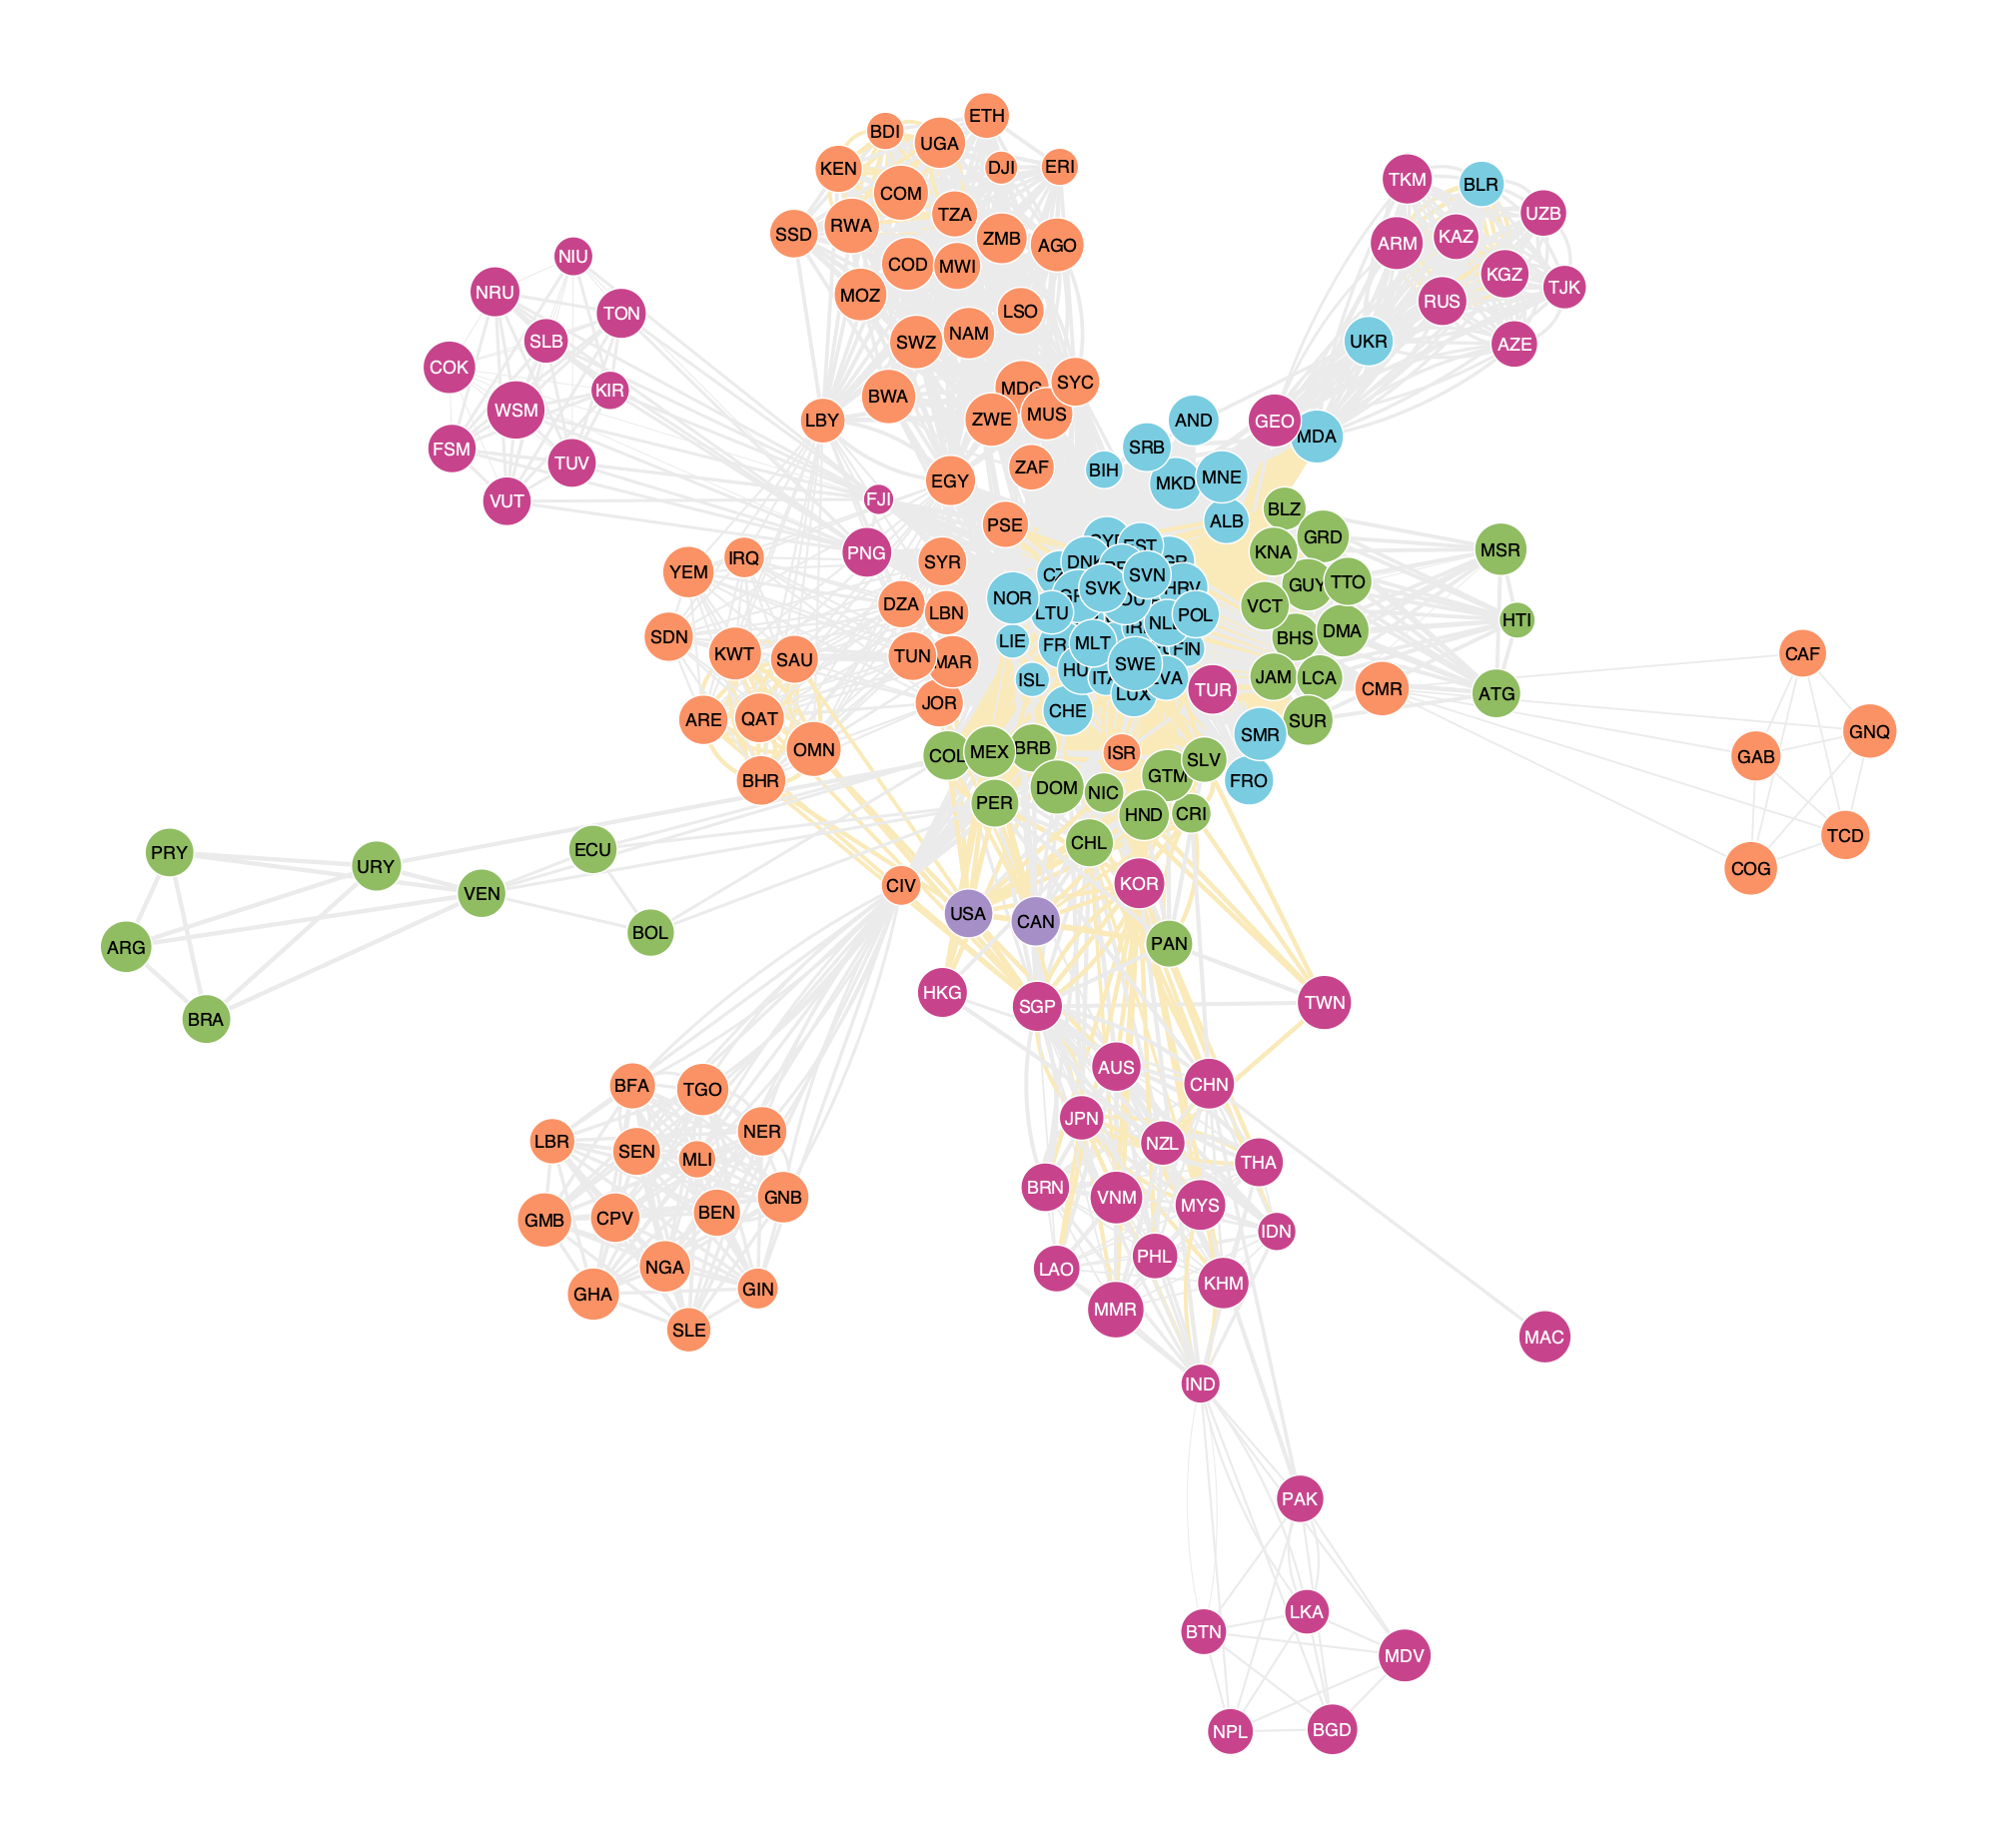

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2a2ff7cd0, at 0x2a2feba00>

In [149]:
gt.graph_draw(trade_graph, pos=pos, 
    vertex_fill_color=node_color,
    vertex_size=gt.prop_to_size(node_size, mi=5, ma=17), #size difference more visible without vertex text
    vertex_color='#FFFFFF',
    vertex_pen_width=0.7,
    vertex_anchor=0,
    vertex_font_family='sans serif',
    vertex_text=country_name,
    edge_color=edge_color,
    edge_pen_width=gt.prop_to_size(edge_weight, mi=0.5, ma=3),
    output_size=(1000,1000))
    #output="../charts/trade_complete.png")

As expected, the graph shows a clustering of nodes by region, indicating that economies which are geographically close tend to be involved in the same agreements. 

European countries, particularly EU members, appear to be the most dense and central set of nodes. The group is surrounded by and closely linked to Latin American countries. Collectively, the countries forming the Community of Latin American and Caribbean States (CELAC) are the EU's fifth largest trading partner <a href="https://www.europarl.europa.eu/RegData/etudes/IDAN/2019/644219/EPRS_IDA(2019)644219_EN.pdf">(European Parliament, 2019)</a>. The EU has both multiparty and bilateral agreements with several Latin American groupings and their individual members (e.g. CARIFORUM, Central American Group). However, a prominent trade bloc, MERCOSUR (Argentina, Brazil, Paraguay, and Uruguay), is isolated from Europe and other Latin American economies. At the time of data collection, MERCOSUR members have not yet signed any agreement with the EU. 

Within Asia, clusters are formed by ASEAN countries, Pacific nations, and former Soviet economies. Meanwhile, Middle East and Africa form 3 separate clusters - South African, Central African, East African and Middle Eastern. NAFTA members USA and Canada are close to the center with connections to Asian and Latin American countries. 

Based on the edges, majority of trade agreements are economic in scope. The ones that contain non-economic provisions are close to the center, the EU cluster, EU agreements with Latin American economies, and some agreements in South East Asia and Middle East, with the exception of a few agreements in Central Asia and East Africa. In terms of edge size and depth, the shallowest agreements appear to be mostly in the periphery, like the agreements among Central African countries and South Asian countries. 

## III. Sub Graphs

It is also interesting to examine how the network differs across time and different groups. To do this, I prune the original network to create several subgraphs that satisfy the given edge filters. 

In [39]:
def create_subgraph(main_graph, filter, largest=False):
    sub = gt.GraphView(main_graph, efilt=filter)

    if largest: # if true get larget connected component only 
        sub = gt.extract_largest_component(sub, prune=True)
    else:
        sub = gt.Graph(sub, prune=True)
        isolated_vertices = [v for v in sub.vertices() if sub.vertex(v).out_degree() == 0 and sub.vertex(v).in_degree() == 0]
        sub.remove_vertex(isolated_vertices, fast=True)

    return sub

### A. By year

First, I create two sub-networks based on when an certain agreement (edge) came into force - before and after 2000.

_**Trade agreements before 2000**_

In [40]:
year_filter = trade_graph.new_edge_property("bool")
year_filter.a = trade_graph.ep.edge_year.a < 2000

sg_yr1 = create_subgraph(trade_graph, year_filter)

In [41]:
pos_yr = gt.sfdp_layout(sg_yr1) # network layout 

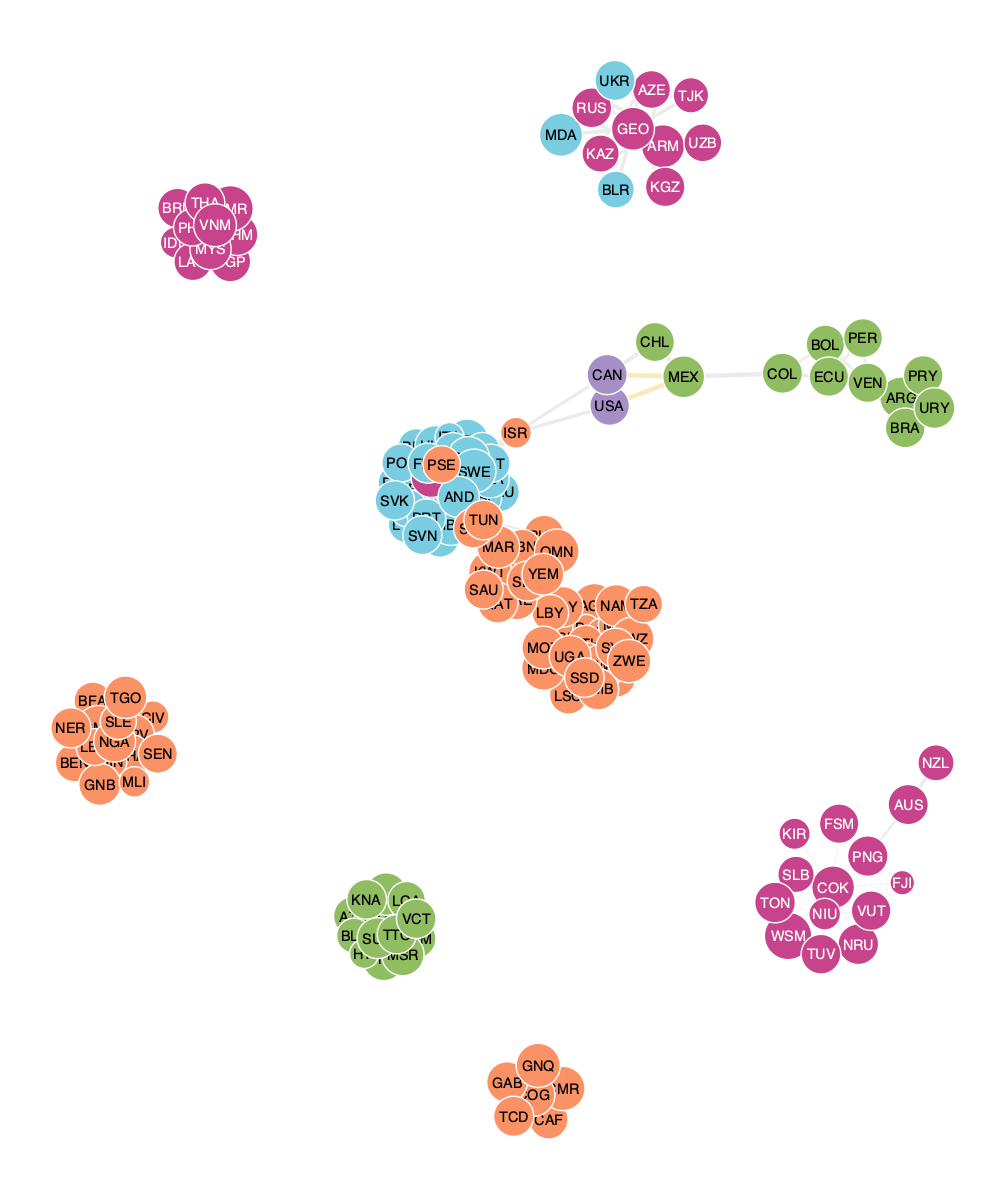

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28ab9b880, at 0x2a4c340a0>

In [42]:
gt.graph_draw(sg_yr1, pos=pos_yr,
            vertex_fill_color=sg_yr1.vp.node_color, 
            vertex_size=12, 
            vertex_text=sg_yr1.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=gt.prop_to_size(sg_yr1.ep.edge_weight, mi=0.3, ma=3),
            edge_color=sg_yr1.ep.edge_color)

It is evident from the graph that agreements before the year 2000 were mostly regional initiatives. Instead of one connected component, there are several small networks consisting of countries from the same part of the world. Within these smaller networks there are also hardly any agreements which cover non-economic issues. 

__*Trade agreements after 2000*__

In [43]:
year_filter = trade_graph.new_edge_property("bool")
year_filter.a = trade_graph.ep.edge_year.a >= 2000

sg_yr2 = create_subgraph(trade_graph, year_filter, largest=True)

In [54]:
pos_yr2 = gt.sfdp_layout(sg_yr2)

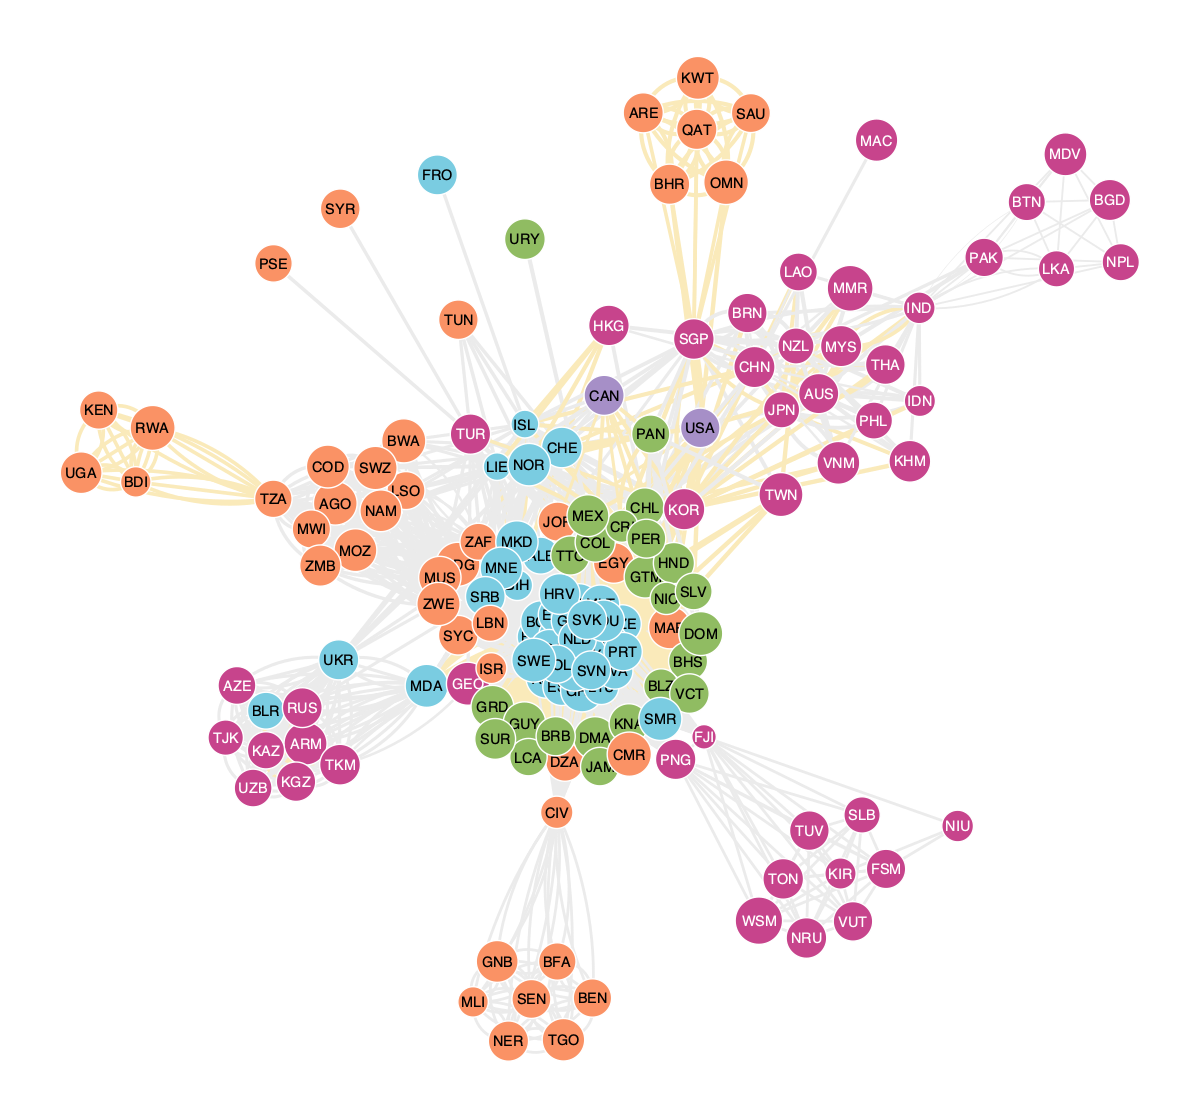

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28ed98a90, at 0x2a4c05040>

In [55]:
gt.graph_draw(sg_yr2, pos=pos_yr2,
            vertex_fill_color=sg_yr2.vp.node_color, 
            vertex_size=12, 
            vertex_text=sg_yr2.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=gt.prop_to_size(sg_yr2.ep.edge_weight, mi=0.3, ma=3),
            edge_color=sg_yr2.ep.edge_color)

In contrast, the trade agreements network after 2000 is more connected with significantly more highlighted edges. During this time, multilateral/multiregional agreements were initiated and issues beyond trade facilitation and tariff reduction became more prominent. 

### B. By scope

In [56]:
scope_filter = trade_graph.new_edge_property("bool")
scope_filter.a = trade_graph.ep.edge_nonecon_prov.a == 1

sg_nonecon = create_subgraph(trade_graph, scope_filter)

In [59]:
pos_scope = gt.sfdp_layout(sg_nonecon)

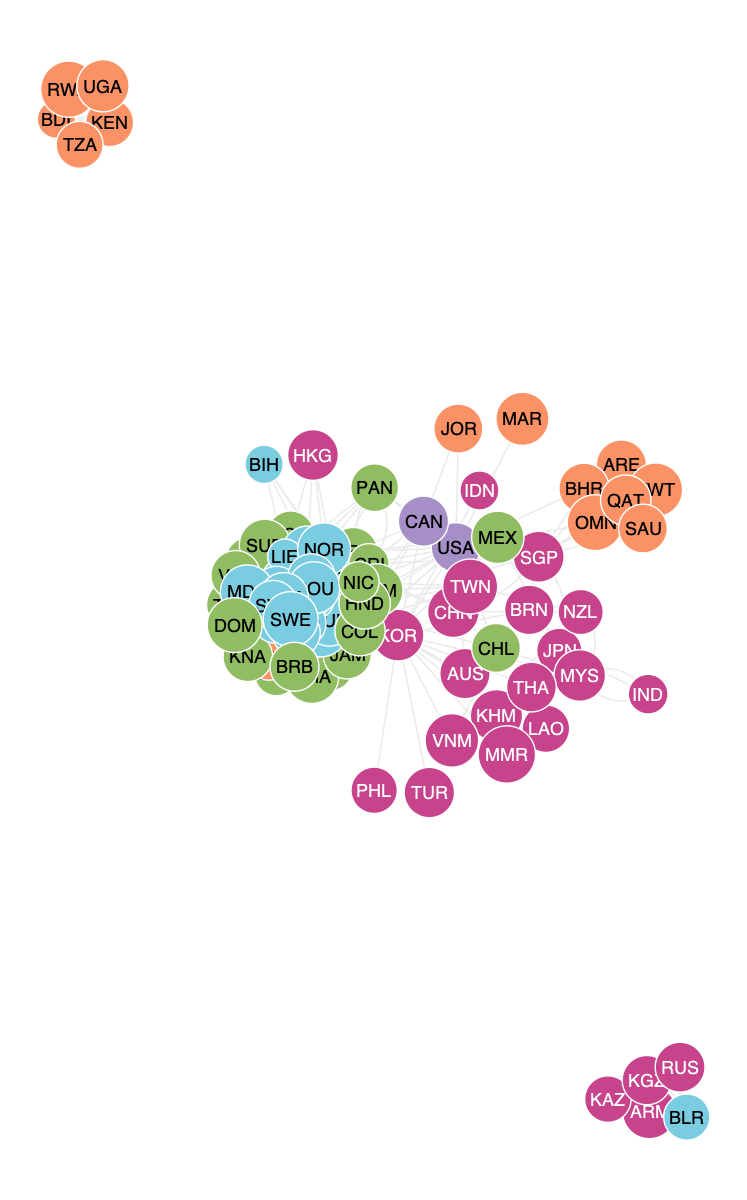

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28ed94ee0, at 0x2a4c285e0>

In [60]:
gt.graph_draw(sg_nonecon, pos=pos_scope,
            vertex_fill_color=sg_nonecon.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_nonecon.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=0.8,
            edge_color='#EBEBEB')

## IV. Descriptive Measures

### A. Degree 

**Degree distribution**

In [339]:
degree_array = trade_graph.degree_property_map("total").a

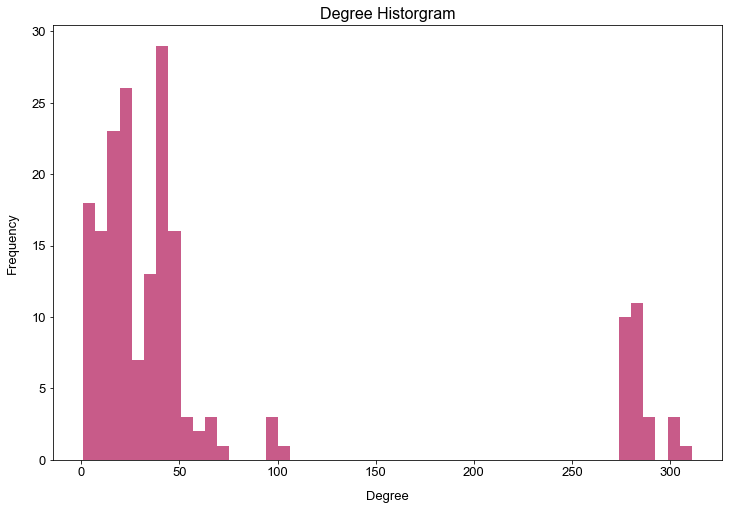

In [383]:
plt.figure(figsize=(12, 8))
plt.hist(degree_array, bins=50, color = "#C85B89")
plt.xlabel('Degree', labelpad=12, fontname='Arial', fontsize=13)
plt.ylabel('Frequency', labelpad=12, fontname='Arial', fontsize=13)
plt.title('Degree Historgram', fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=13)
plt.yticks(fontname='Arial', fontsize=13)

plt.show()

In [247]:
# create dataframe of country, region, node degree
country_name_list = [trade_graph.vp.country_name[v] for v in trade_graph.vertices()]
region_name_list = [trade_graph.vp.node_region[v] for v in trade_graph.vertices()]

degree_df = pd.DataFrame({"country_name": country_name_list, "region": region_name_list, "degree": degree_array})
degree_df.head()

country_name              region  degree
0          AGO  Sub-Saharan Africa      36
1          BDI  Sub-Saharan Africa      32
2          BWA  Sub-Saharan Africa      22
3          COD  Sub-Saharan Africa      37
4          COM  Sub-Saharan Africa      23

In [248]:
# group EU as one economy
df_europe = degree_df[degree_df['region'] == 'Europe']

noneu = ['ALB', 'AND', 'BLR', 'BIH', 'ISL', 'LIE', 'MDA', 'MNE', 'NOR', 'SRB', 'CHE']
df_europe = df_europe[~df_europe['country_name'].isin(noneu)]
df_eu = pd.DataFrame({"country_name": ['EU'], "region": ['Europe'], "degree": [df_europe['degree'].mean()]}) #ave degree of EU countries

degree_df = pd.concat([degree_df, df_eu], ignore_index=True)
degree_df = degree_df[~degree_df['country_name'].isin(df_europe['country_name'])]

**Top 20 countries by degree**

In [249]:
degree_df.sort_values(by='degree', ascending=True, inplace=True)
top_20_countries = degree_df.tail(20).reset_index(drop=True)

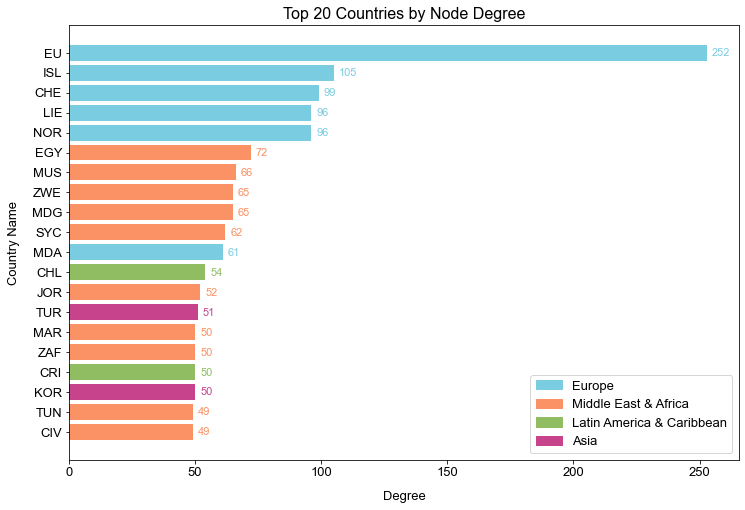

In [382]:
colors = top_20_countries['region'].map(region_colors)

plt.figure(figsize=(12, 8))
plt.barh(top_20_countries['country_name'], top_20_countries['degree'], color = colors)
plt.xlabel('Degree', labelpad=12, fontname='Arial', fontsize=13)
plt.ylabel('Country Name', labelpad=12, fontname='Arial', fontsize=13)
plt.title('Top 20 Countries by Node Degree', fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=13)
plt.yticks(fontname='Arial', fontsize=13)

for i, degree in enumerate(top_20_countries['degree']):
    plt.text(degree + 2, i, str(int(degree)), ha='left', va='center', 
             color=colors[i], fontname='Arial',fontsize=11)

legend_colors = {'Europe': '#7ACCE1', 'Middle East & Africa': '#FA9265', 
                 'Latin America & Caribbean': '#90BC62', 'Asia': '#C7448C'}

legend_patches = [mpatches.Patch(color=color, label=region) for color, region in zip(legend_colors.values(), legend_colors.keys())]
legend = plt.legend(handles=legend_patches, loc='lower right', prop={'family': 'Arial', 'size': 13})

plt.show()

**Degree and depth correlation**

In [377]:
depth_country = trade_df.groupby('iso1')['depth_le'].mean()
depth_country_df = pd.DataFrame({'country_name': depth_country.index,
                                 'ave_depth_le': depth_country.values})

degree_df = degree_df.merge(depth_country_df, on='country_name')

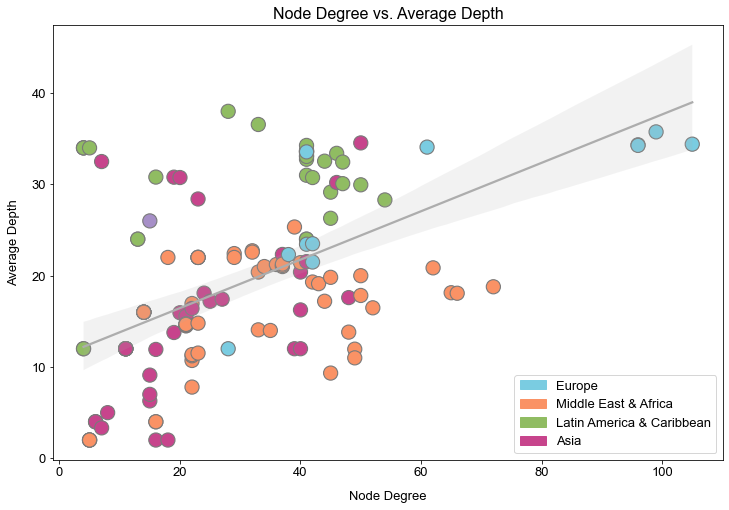

In [463]:
colors = degree_df['region'].map(region_colors)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='degree', y='ave_depth_le', data=degree_df, color=colors, s=200, edgecolor='#7A7A7A')
sns.regplot(x='degree', y='ave_depth_le', data=degree_df, scatter=False, color='#ADADAD', robust=True)
plt.xlabel('Node Degree', labelpad=12, fontname='Arial', fontsize=13)
plt.ylabel('Average Depth', labelpad=12, fontname='Arial', fontsize=13)
plt.title('Node Degree vs. Average Depth', fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=13)
plt.yticks(fontname='Arial', fontsize=13)

legend_colors = {'Europe': '#7ACCE1', 'Middle East & Africa': '#FA9265', 
                 'Latin America & Caribbean': '#90BC62', 'Asia': '#C7448C'}

legend_patches = [mpatches.Patch(color=color, label=region) for color, region in zip(legend_colors.values(), legend_colors.keys())]
legend = plt.legend(handles=legend_patches, loc='lower right', prop={'family': 'Arial', 'size': 13})

plt.show()


### B. Centrality 

In [176]:
color_map = colors.LinearSegmentedColormap.from_list('color_map', ['#FFFFC9', '#EA683A','#E35934', '#D53C2A', '#C71F1F'])

#### i. Full network

*Eigenvector centrality*

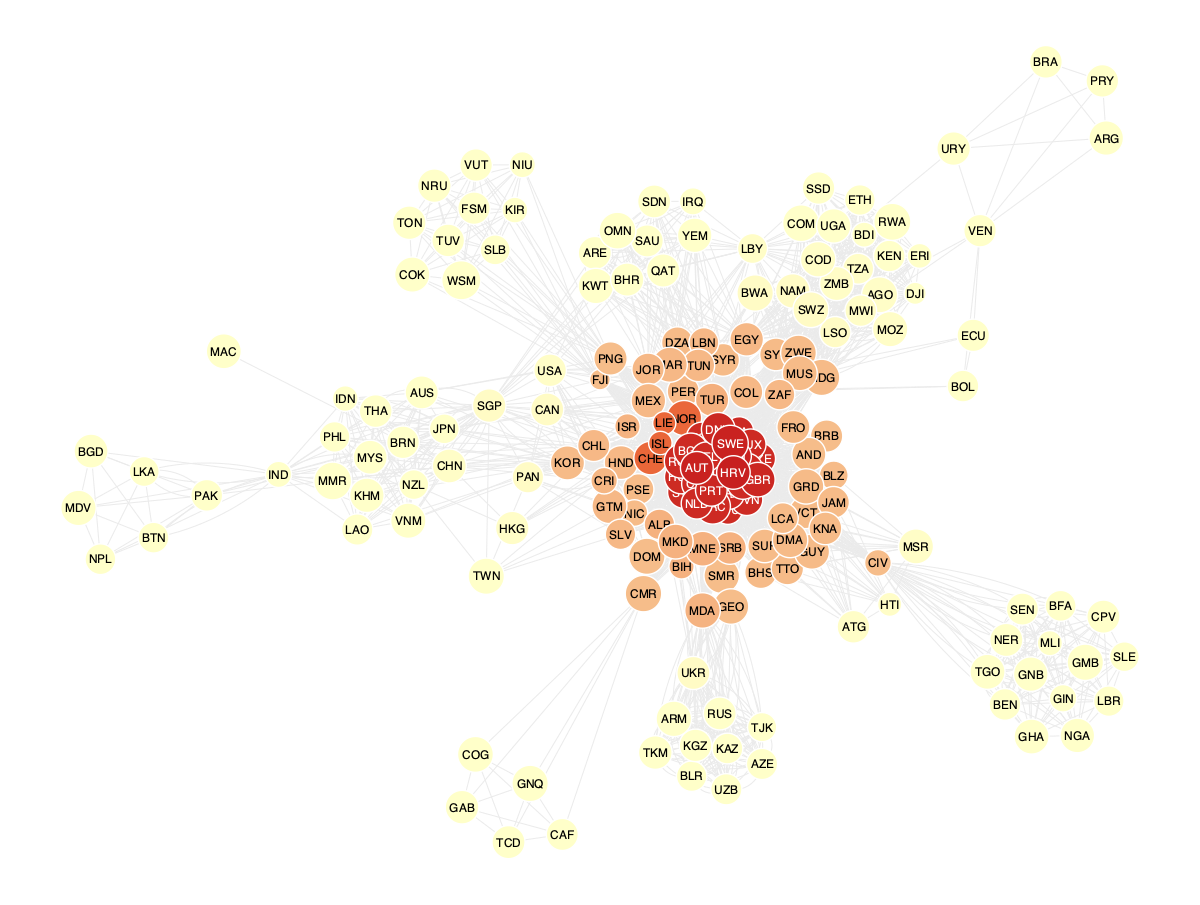

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29b8117c0, at 0x28bfab1f0>

In [177]:
ee, x = gt.eigenvector(trade_graph)

# network based on centrality
gt.graph_draw(trade_graph, pos=pos, 
              vertex_fill_color=x,
              vertex_size=gt.prop_to_size(x, mi=8, ma=15),
              vcmap=color_map,
              vertex_text=country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)


*Betweenness centrality*

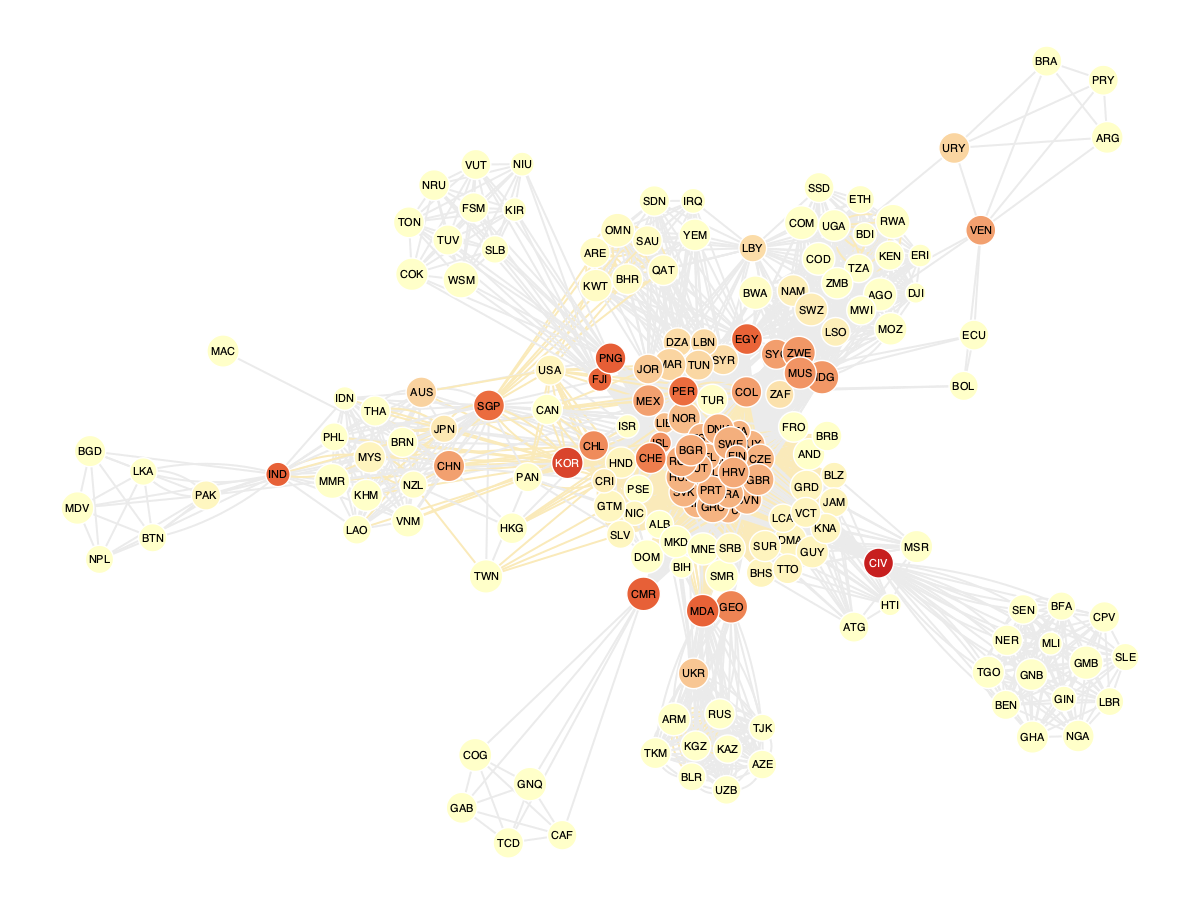

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29b8117c0, at 0x28bf804f0>

In [178]:
vp, ep = gt.betweenness(trade_graph)
gt.graph_draw(trade_graph, pos=pos, vertex_fill_color=vp,
              vertex_size=gt.prop_to_size(vp, mi=8, ma=15),
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color=edge_color,
              vcmap=color_map,
              vertex_text=country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              vorder=vp)

#### ii. Agreements with non-economic provisions

*Eigenvector centrality*

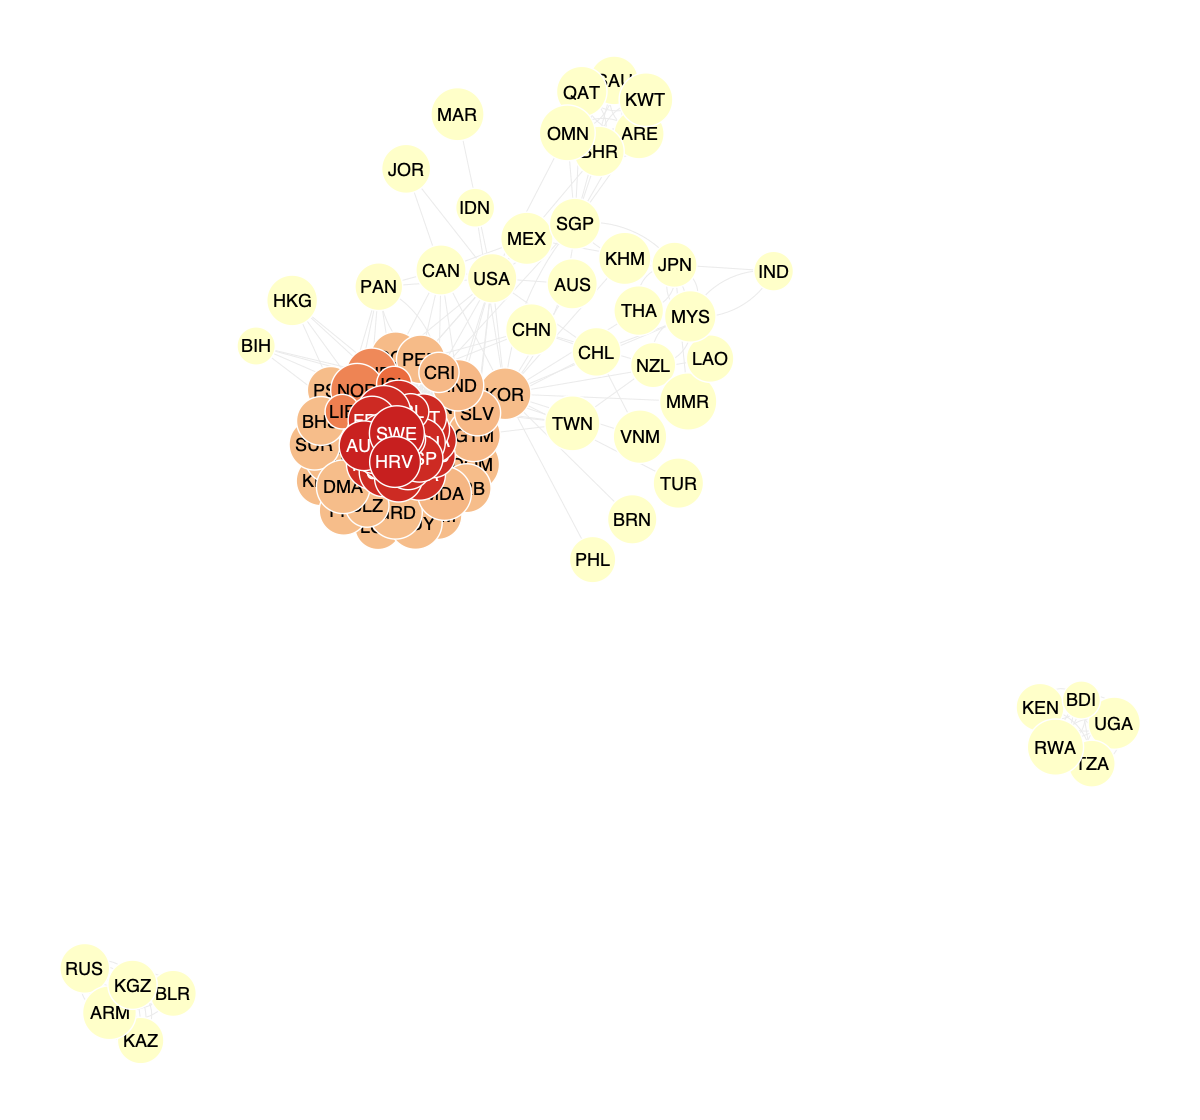

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf88df0, at 0x28bfab760>

In [179]:
ee, x = gt.eigenvector(sg_nonecon)

# network based on centrality
gt.graph_draw(sg_nonecon, pos=pos_scope, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_nonecon.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

*Betweenness centrality*

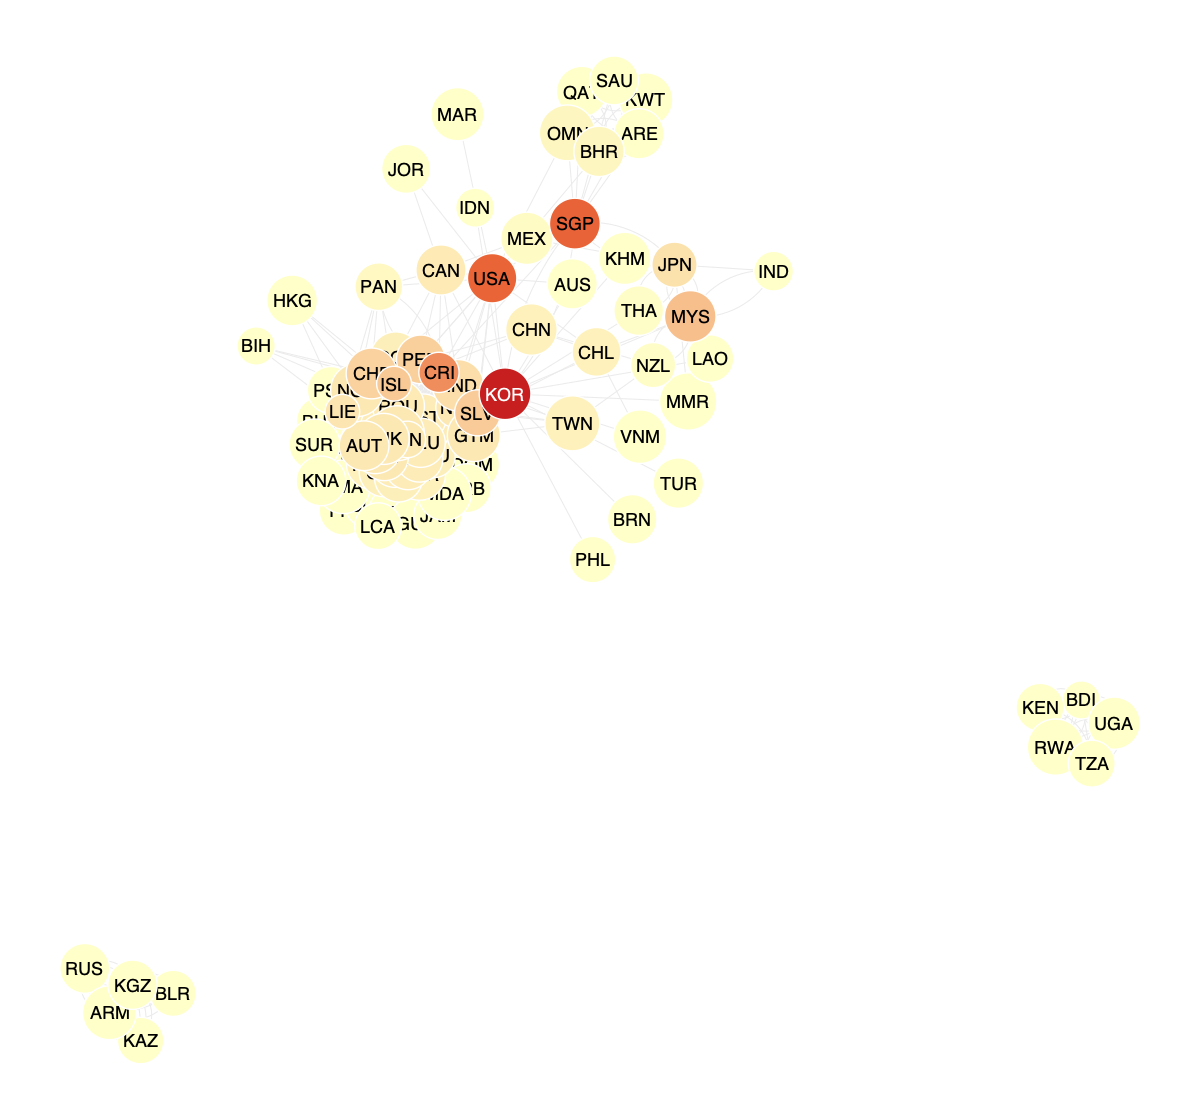

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf88df0, at 0x28bfab310>

In [180]:
vp, ep = gt.betweenness(sg_nonecon)
gt.graph_draw(sg_nonecon, pos=pos_scope, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_nonecon.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

#### iii. Agreements before 2000

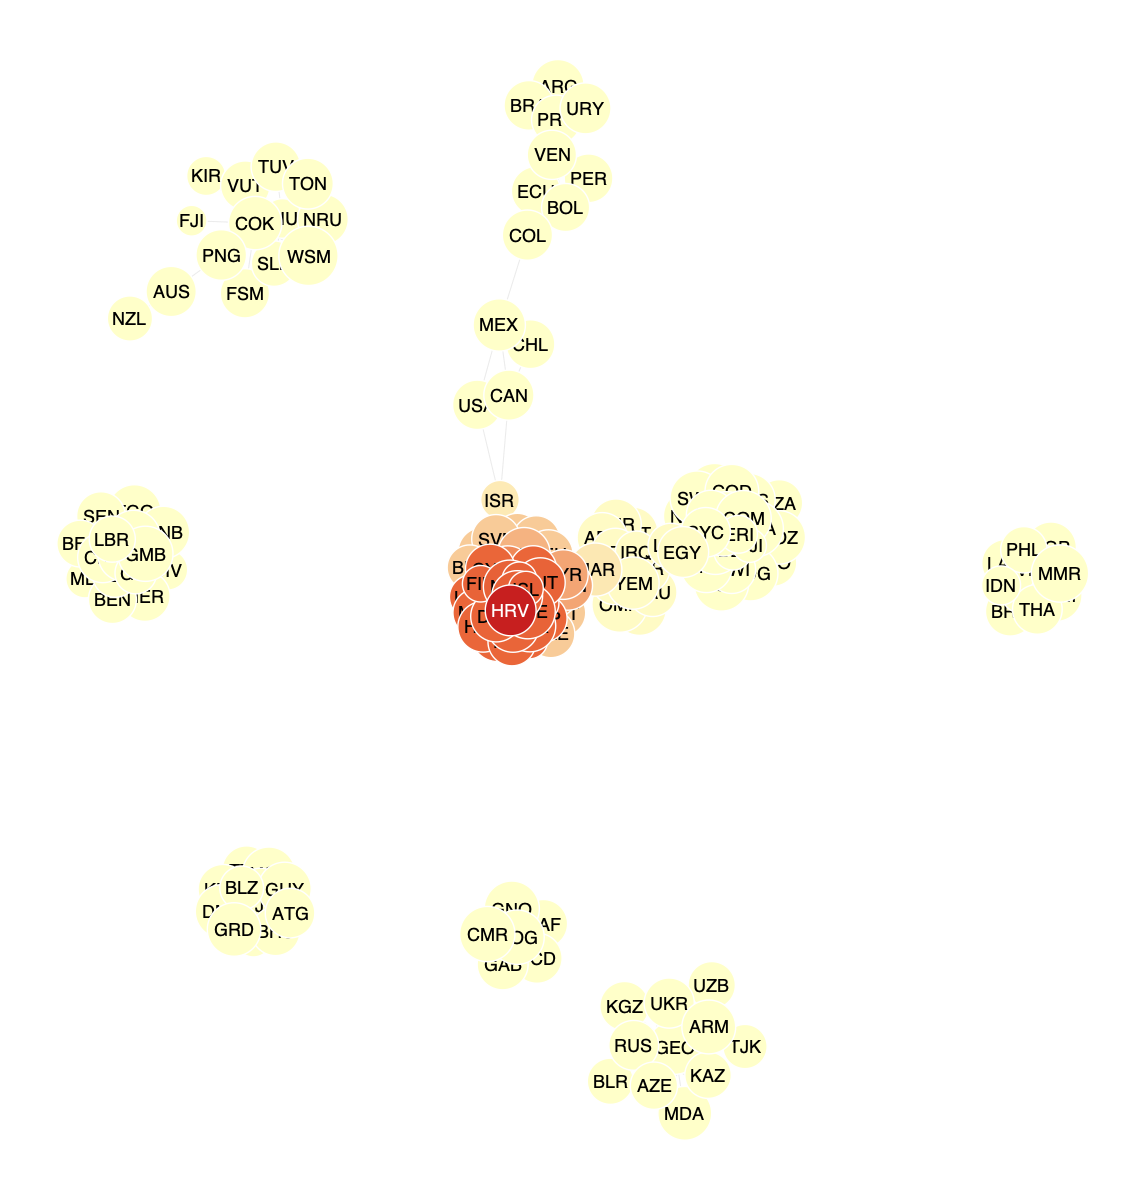

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80190, at 0x28a4db100>

In [181]:
ee, x = gt.eigenvector(sg_yr1)
gt.graph_draw(sg_yr1, pos=pos_yr, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_yr1.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

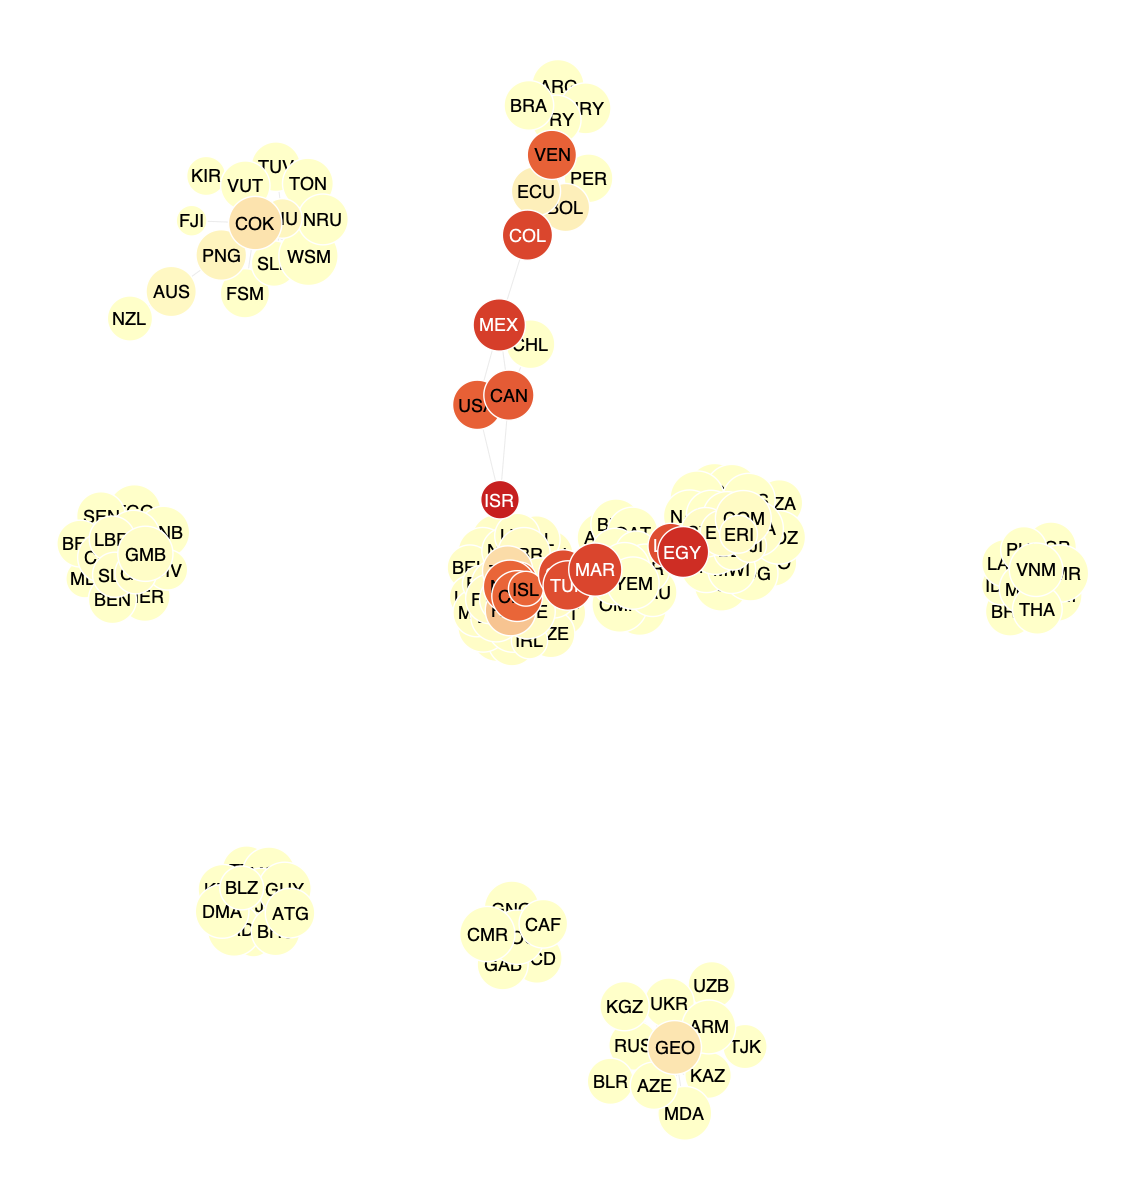

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80190, at 0x28bd78d30>

In [182]:
vp, ep = gt.betweenness(sg_yr1)
gt.graph_draw(sg_yr1, pos=pos_yr, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_yr1.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

#### iv. Agreements after 2000

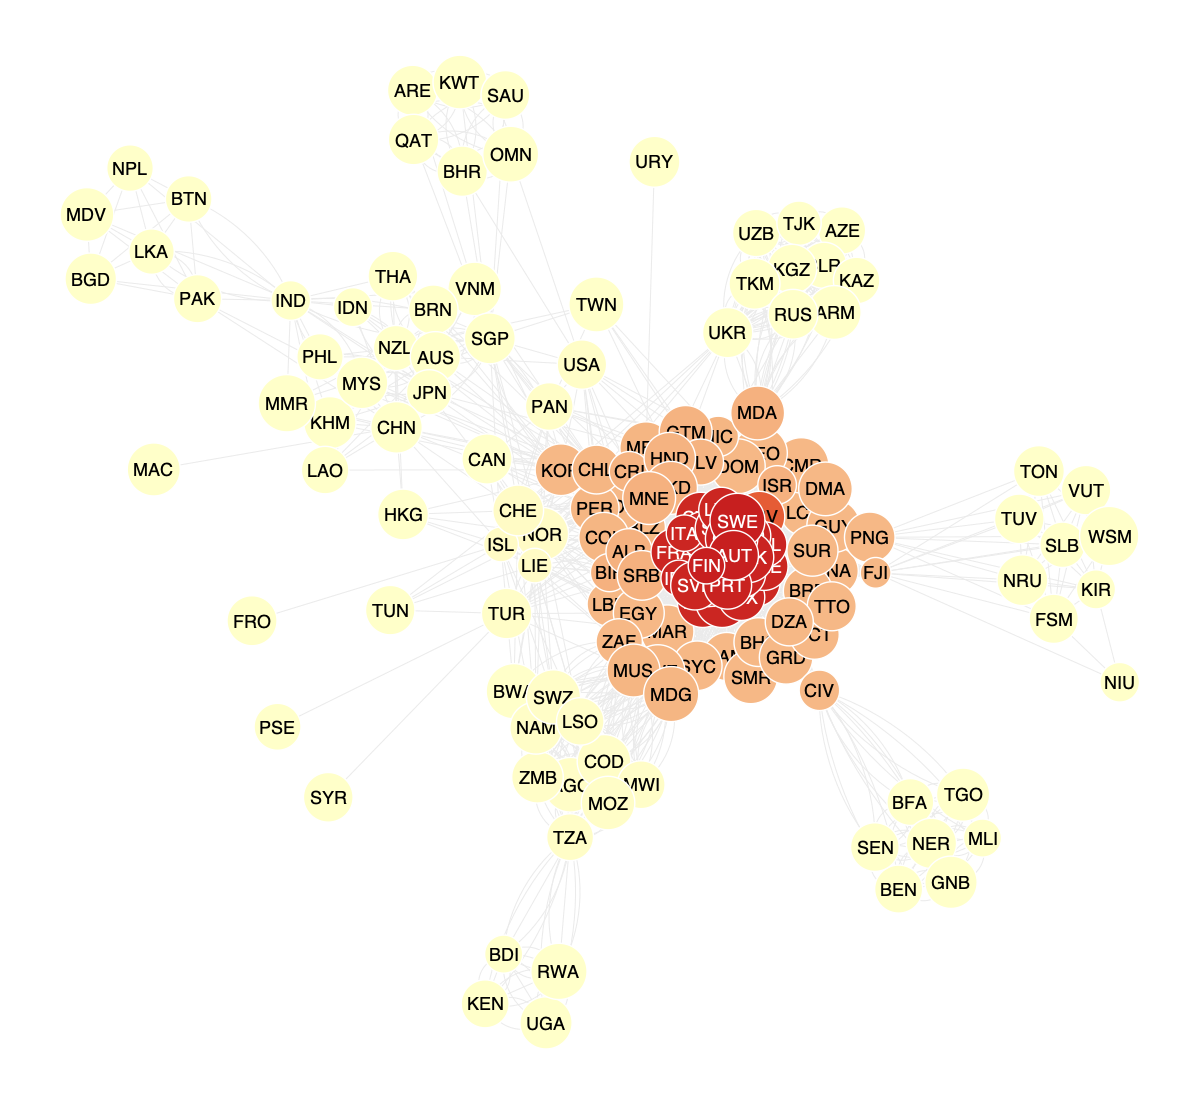

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80040, at 0x287185670>

In [183]:
ee, x = gt.eigenvector(sg_yr2)
gt.graph_draw(sg_yr2, pos=pos_yr2, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_yr2.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

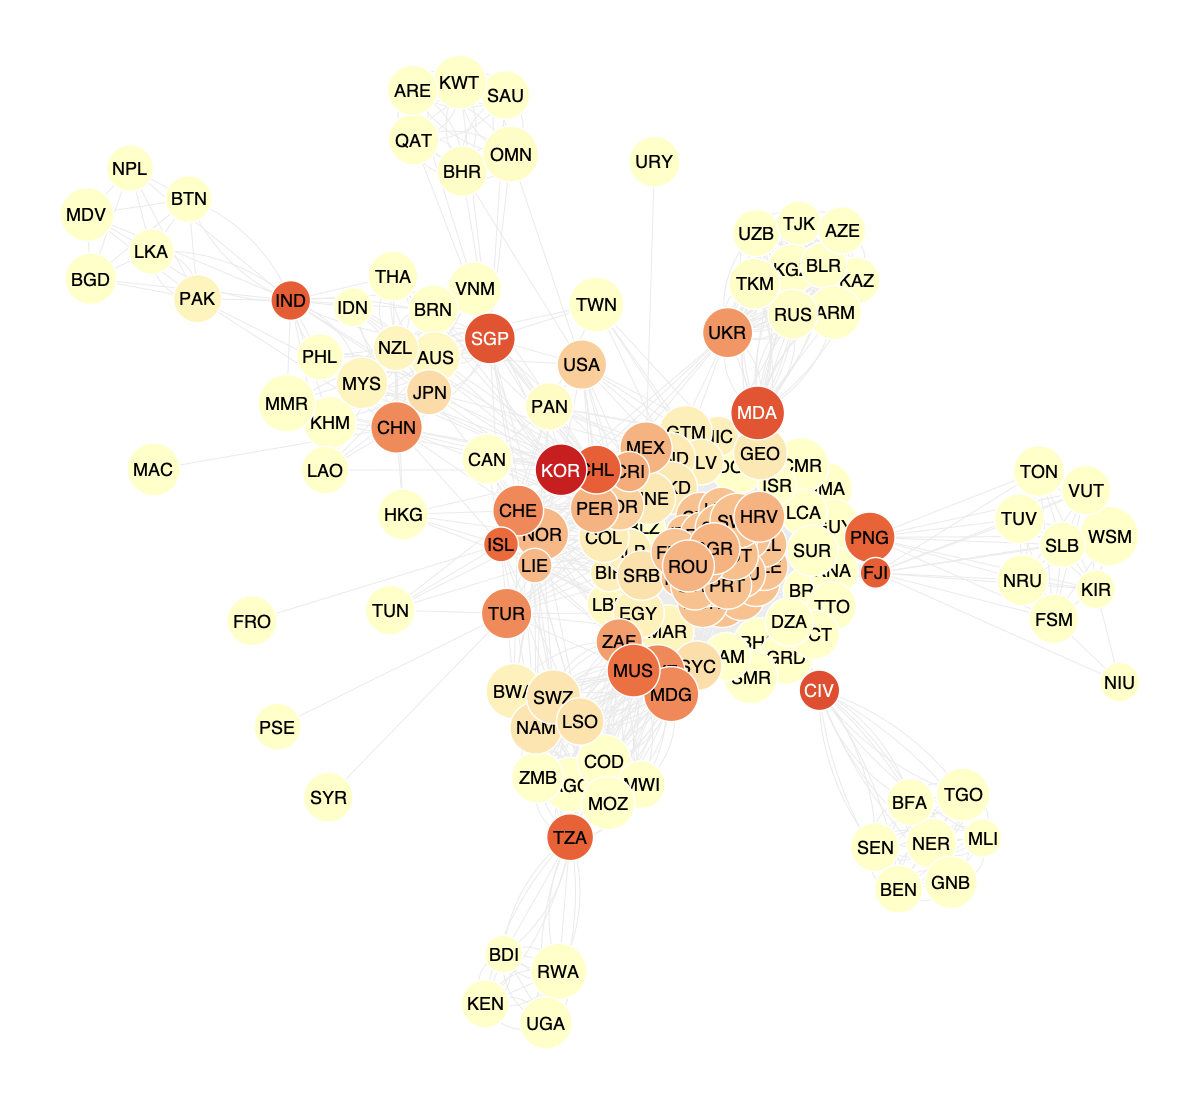

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28bf80040, at 0x28bfabd60>

In [184]:
vp, ep = gt.betweenness(sg_yr2)
gt.graph_draw(sg_yr2, pos=pos_yr2, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_yr2.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

### C. Community Detection 